# Decision Trees for Development Classification: Unveiling Global Patterns

## What is a Decision Tree?

A decision tree is a supervised machine learning algorithm used for classification and regression tasks. It works by recursively splitting the data into subsets based on feature values, forming a tree-like structure of decision rules. Each internal node represents a test on a feature, each branch corresponds to an outcome of the test, and each leaf node represents a class label (for classification) or a value (for regression). Decision trees are valued for their interpretability, as the resulting rules can be visualized and easily understood by humans. In this notebook, we use a decision tree to classify countries as developing or developed based on key socioeconomic and environmental indicators.

## Background
Understanding what drives a country’s development status is crucial for policymakers and researchers. Decision Trees offer a powerful, interpretable way to uncover hierarchical decision rules that distinguish developing and developed countries. By analyzing economic, social, and environmental indicators, we aim to identify critical thresholds and provide transparent insights for policy recommendations.

## Objectives
- Create interpretable decision rules for classifying countries as developing (0) or developed (1)
- Identify key thresholds in development indicators
- Analyze feature importance hierarchies
- Study interaction effects between indicators
- Provide actionable policy recommendations

## Research Questions
1. What are the key thresholds that distinguish development levels?
2. How do environmental factors influence development paths?
3. What role does military expenditure play in development?
4. Which combinations of indicators best predict development status?

## Data Context
We use data from the World Bank’s World Development Indicators (WDI) database for 2021 to explore development patterns. Our indicators include GDP per capita, Life Expectancy, GHG Emissions per Capita, Labor Force Participation, Military Expenditure, and Debt Service. Development status is defined using GNI per capita (threshold: $12,695), aligning with World Bank standards.

In [2]:
# Import required libraries
import wbdata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           confusion_matrix, classification_report)
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure visualizations
#plt.style.use('seaborn-whitegrid')
sns.set_context('talk')  # Larger font sizes for readability
%matplotlib inline

Key '-9014293116431689464' not in persistent cache.
Key '-5749461014433131158' not in persistent cache.
Key '4535895882636525286' not in persistent cache.
Key '4790133295185851249' not in persistent cache.
Key '1008936108549552730' not in persistent cache.
Key '1301941828480200918' not in persistent cache.
Key '7121855884018634585' not in persistent cache.
Key '4821011343028085187' not in persistent cache.
Key '-7805818675143032762' not in persistent cache.
Key '-4540986573144474456' not in persistent cache.
Key '-7099360651447966329' not in persistent cache.
Key '-2473248977967029498' not in persistent cache.
Key '-6163540233920799324' not in persistent cache.
Key '1045820536580854771' not in persistent cache.
Key '3725098845180967919' not in persistent cache.
Key '-4521541182986553377' not in persistent cache.
Key '198139071093995363' not in persistent cache.
Key '-7963248105545899809' not in persistent cache.
Key '8829056514149714997' not in persistent cache.
Key '-19544980745769101

## Data Collection and Preprocessing

We fetch data for 13 countries, ensuring a mix of developing (e.g., Yemen, Zambia) and developed (e.g., USA, Japan) nations. The year 2021 is chosen for better data coverage. We preprocess the data by computing derived metrics (e.g., GHG Emissions per Capita), applying log transformations, and imputing missing values with medians.

In [3]:
# Define indicators
indicators = {
    "NY.GDP.PCAP.CD": "GDP per capita",
    "SP.DYN.LE00.IN": "Life Expectancy",
    "EN.GHG.ALL.MT.CE.AR5": "Total GHG Emissions",
    "SP.POP.TOTL": "Population",
    "SL.TLF.CACT.ZS": "Labor Force Participation",
    "MS.MIL.XPND.GD.ZS": "Military Expenditure",
    "DT.TDS.DPPF.XP.ZS": "Debt Service"
}

# Fetch and process data
def fetch_data():
    print("Fetching data from World Bank...")
    data = {}
    for indicator in indicators.keys():
        print(f"Fetching {indicators[indicator]}...")
        result = wbdata.get_data(indicator)
        data[indicators[indicator]] = result
        
    # Convert to DataFrame
    print("\nProcessing data...")
    rows = []
    for indicator_name, indicator_data in data.items():
        for entry in indicator_data:
            if entry['value'] is not None:
                rows.append({
                    'country': entry['country']['value'],
                    'year': entry['date'],
                    'indicator': indicator_name,
                    'value': float(entry['value'])
                })
    
    # Create DataFrame
    df = pd.DataFrame(rows)
    
    # Pivot and process
    df = df.pivot_table(
        index=['country', 'year'],
        columns='indicator',
        values='value'
    ).reset_index()
    
    # Sort and compute derived metrics
    df['year'] = pd.to_numeric(df['year'])
    df = df.sort_values('year', ascending=False)
    df["GHG Emissions per Capita"] = (df["Total GHG Emissions"] * 1_000_000) / df["Population"]
    df = df.drop(columns=["Total GHG Emissions", "Population"])
    
    return df

# Fetch the data
df = fetch_data()

Fetching data from World Bank...
Fetching GDP per capita...


Key '-9014293116431689464' not in persistent cache.


Fetching Life Expectancy...


Fetching Total GHG Emissions...


Fetching Population...


Fetching Labor Force Participation...


Fetching Military Expenditure...


Fetching Debt Service...

Processing data...


In [4]:
def preprocess_data(df):
    # Take most recent year's data for each country
    df_recent = df.sort_values('year', ascending=False).groupby('country').first().reset_index()
    
    # Log transform GDP and GHG emissions
    df_recent['GDP per capita (log)'] = np.log(df_recent['GDP per capita'])
    df_recent['GHG Emissions per Capita (log)'] = np.log(df_recent['GHG Emissions per Capita'])
    
    # Handle missing values
    numeric_columns = df_recent.select_dtypes(include=[np.number]).columns
    df_recent[numeric_columns] = df_recent[numeric_columns].fillna(df_recent[numeric_columns].mean())
    
    # Create development categories based on GDP per capita
    df_recent['Development Category'] = pd.qcut(
        df_recent['GDP per capita'],
        q=4,
        labels=['Low', 'Lower-Middle', 'Upper-Middle', 'High']
    )
    
    return df_recent

# Preprocess the data
df_processed = preprocess_data(df)

# Display basic information about the processed dataset
print("\nProcessed Dataset Info:")
print(df_processed.info())

print("\nSample of processed data:")
print(df_processed.head())


Processed Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   country                         265 non-null    object  
 1   year                            265 non-null    int64   
 2   Debt Service                    265 non-null    float64 
 3   GDP per capita                  265 non-null    float64 
 4   Labor Force Participation       265 non-null    float64 
 5   Life Expectancy                 265 non-null    float64 
 6   Military Expenditure            265 non-null    float64 
 7   GHG Emissions per Capita        265 non-null    float64 
 8   GDP per capita (log)            265 non-null    float64 
 9   GHG Emissions per Capita (log)  265 non-null    float64 
 10  Development Category            265 non-null    category
dtypes: category(1), float64(8), int64(1), object(1)
memory usag

In [5]:
# Define feature sets
numeric_features = [
    'GDP per capita', 'Life Expectancy', 'GHG Emissions per Capita',
    'Labor Force Participation', 'Military Expenditure', 'Debt Service',
    'GDP per capita (log)', 'GHG Emissions per Capita (log)'
]
categorical_features = ['Region']

In [6]:
df_processed.head()

indicator,country,year,Debt Service,GDP per capita,Labor Force Participation,Life Expectancy,Military Expenditure,GHG Emissions per Capita,GDP per capita (log),GHG Emissions per Capita (log),Development Category
0,Afghanistan,2024,2.244082,415.707417,37.496000,66.035000,1.827934,0.710657,6.029982,-0.341566,Low
1,Africa Eastern and Southern,2024,10.966825,1659.515290,69.182409,65.146291,0.999402,1.928998,7.414281,0.657001,Low
2,Africa Western and Central,2024,7.389198,1568.724310,71.282939,58.855722,1.177399,1.778662,7.358018,0.575862,Low
3,Albania,2024,6.000117,8575.171134,60.675000,79.602000,1.743992,2.794530,9.056626,1.027664,Upper-Middle
4,Algeria,2024,0.443858,5364.027950,40.760000,76.261000,8.171721,5.562579,8.587470,1.716062,Lower-Middle


In [7]:
df_processed['Development Status'] = df_processed['GDP per capita'].apply(lambda x: 1 if x > 12695 else 0)

In [8]:
df_processed['Development Status'] = df_processed['Development Status'].astype(int)

In [9]:
df_processed_ = df_processed['Development Status'].unique()

In [10]:
df_processed_

array([0, 1])

## Exploratory Data Analysis: Setting the Stage

Before building our decision tree, we explore the data to identify patterns that might guide the model’s splits. We focus on answering: Which indicators best distinguish development levels? Are there clear thresholds? How do environmental and military factors contribute? We use the full dataset for exploration to ensure all categories are represented.

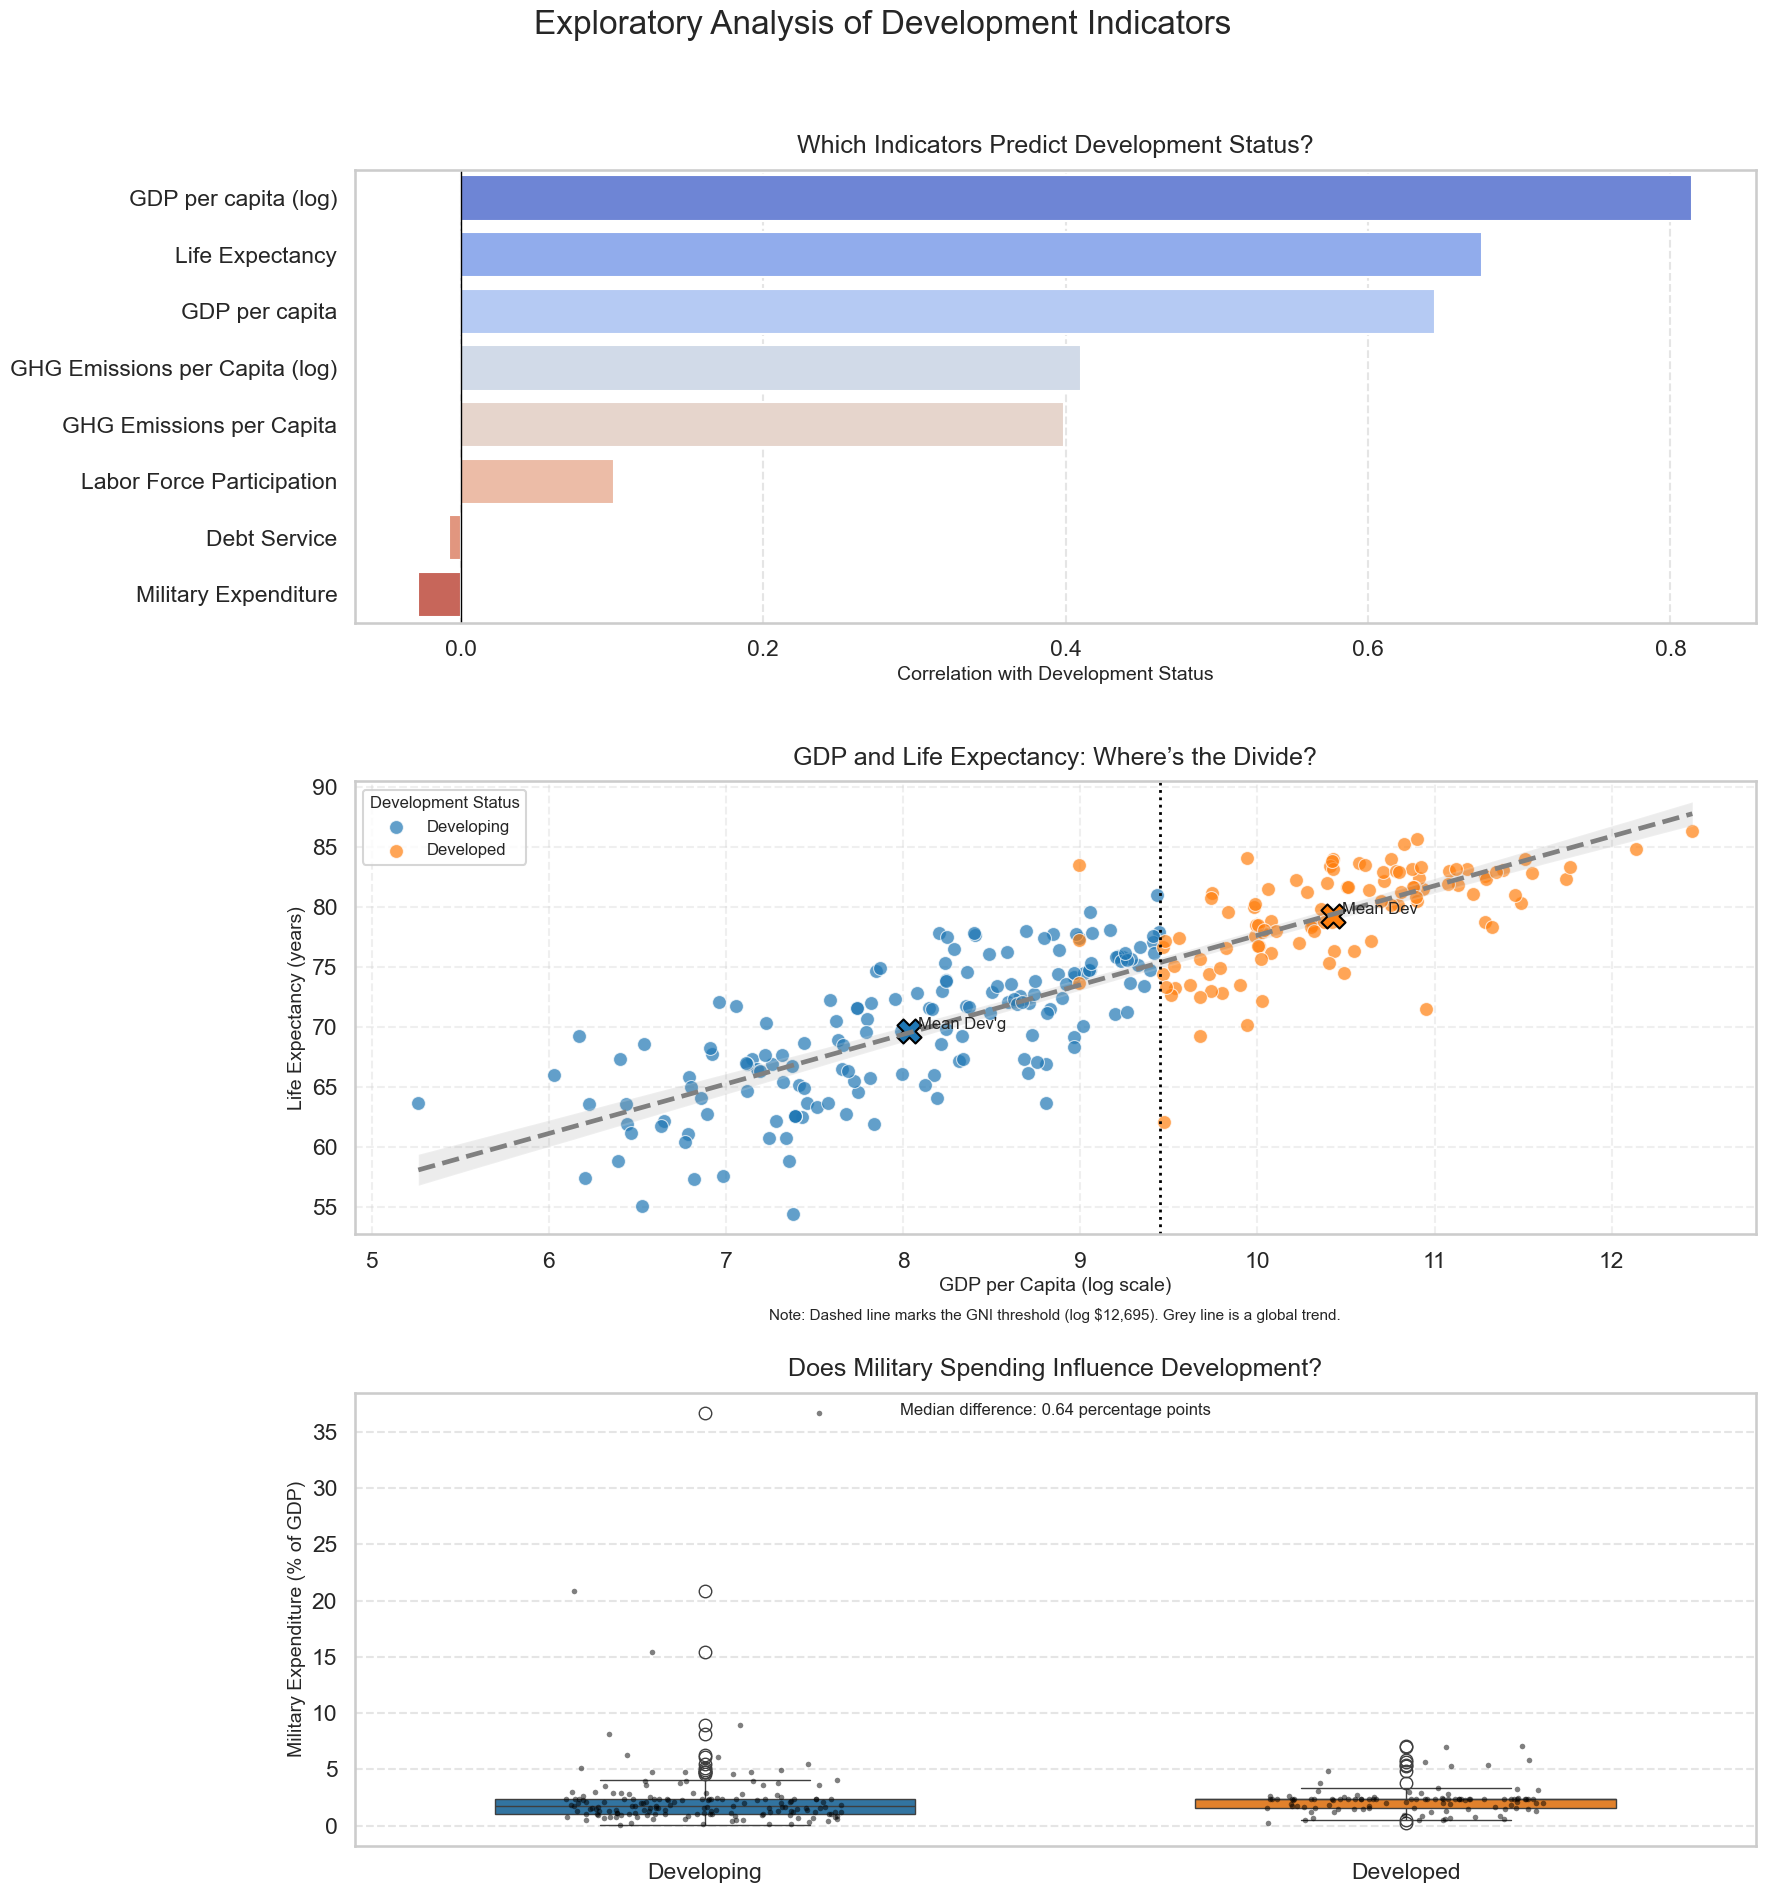

In [ ]:
def plot_exploratory_analysis(df):
    sns.set_theme(style="whitegrid", context="talk")
    
    # Prepare data
    corr = (df[numeric_features + ['Development Status']]
            .corr()['Development Status']
            .drop('Development Status')
            .sort_values(ascending=False))
    
    # Compute cluster means for scatter
    means = df.groupby('Development Status')[['GDP per capita (log)', 'Life Expectancy']].mean()
    
    # Define palette
    status_palette = {0: "#1f77b4", 1: "#ff7f0e"}  # blue/orange
    
    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=(18, 20),
                             gridspec_kw={"height_ratios": [1, 1, 1]})
    fig.suptitle("Exploratory Analysis of Development Indicators", fontsize=24, y=0.95)
    
    # 1) Horizontal Bar: Correlations
    ax = axes[0]
    sns.barplot(x=corr.values, y=corr.index, palette="coolwarm", ax=ax)
    ax.set_xlabel("Correlation with Development Status", fontsize=14)
    ax.set_ylabel("")
    ax.axvline(0, color="black", linewidth=1)
    ax.set_title("Which Indicators Predict Development Status?", fontsize=18, pad=12)
    ax.grid(axis="x", linestyle="--", alpha=0.5)
    
    # 2) Scatter + Regression: GDP vs Life Expectancy
    ax = axes[1]
    for status, color in status_palette.items():
        subset = df[df['Development Status'] == status]
        sns.scatterplot(data=subset,
                        x='GDP per capita (log)',
                        y='Life Expectancy',
                        color=color,
                        label=f"{'Developing' if status==0 else 'Developed'}",
                        s=100, alpha=0.7,
                        ax=ax)
    # regression line (all data)
    sns.regplot(data=df,
                x='GDP per capita (log)',
                y='Life Expectancy',
                scatter=False,
                color='gray',
                line_kws={'linestyle':'--'},
                ax=ax)
    # threshold line
    threshold = np.log1p(12695)
    ax.axvline(threshold, color="black", linestyle=":", linewidth=2)
    # annotate cluster centroids
    for status, row in means.iterrows():
        ax.scatter(row['GDP per capita (log)'], row['Life Expectancy'],
                   s=300, marker="X", color=status_palette[status], edgecolor="black")
        ax.text(row['GDP per capita (log)'] + 0.05,
                row['Life Expectancy'] + 0.2,
                "Mean Dev" if status==1 else "Mean Dev'g",
                fontsize=12)
    
    ax.set_title("GDP and Life Expectancy: Where’s the Divide?", fontsize=18, pad=12)
    ax.set_xlabel("GDP per Capita (log scale)", fontsize=14)
    ax.set_ylabel("Life Expectancy (years)", fontsize=14)
    ax.legend(title="Development Status", fontsize=12, title_fontsize=12)
    ax.text(0.5, -0.19,
            "Note: Dashed line marks the GNI threshold (log $12,695). Grey line is a global trend.",
            transform=ax.transAxes, ha="center", fontsize=11)
    ax.grid(True, linestyle="--", alpha=0.3)
    
    
    # 3) Box + Strip: Military Expenditure
    ax = axes[2]
    order = ['Developing', 'Developed']
    df['DevCat'] = df['Development Status'].map({0:'Developing', 1:'Developed'})
    
    sns.boxplot(data=df,
                x='DevCat',
                y='Military Expenditure',
                order=order,
                palette=[status_palette[0], status_palette[1]],
                width=0.6,
                ax=ax)
    sns.stripplot(data=df,
                          x='DevCat',
                          y='Military Expenditure',
                          order=order,
                          color='black',
                          size=4,
                          alpha=0.5,
                          jitter=0.2,
                          ax=ax)
    
    medians = df.groupby('DevCat')['Military Expenditure'].median()
    diff = medians['Developed'] - medians['Developing']
    ax.text(0.5, 0.95,
            f"Median difference: {diff:.2f} percentage points",
            transform=ax.transAxes,
            fontsize=12, ha='center',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    ax.set_title("Does Military Spending Influence Development?", fontsize=18, pad=12)
    ax.set_xlabel("")
    ax.set_ylabel("Military Expenditure (% of GDP)", fontsize=14)
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    
    plt.subplots_adjust(top=1, hspace=0.3)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()
# Plot exploratory analysis
plot_exploratory_analysis(df_processed)
  # Increase horizontal spacing between subplots

## Insights from Exploration

- **Key Predictors**: GDP per capita and Life Expectancy are strongly correlated with development status, likely forming the primary splits in our tree.
- **Thresholds**: Developed countries exceed a GDP per capita of $12,695 and a life expectancy of ~80 years, suggesting clear decision boundaries.
- **Military Spending**: Developing countries allocate more to military expenditure, which may hinder development by diverting resources.

These patterns set the stage for our decision tree to uncover hierarchical rules and thresholds.

## Model Implementation: Building the Decision Tree

We train a Decision Tree Classifier to classify countries as developing (0) or developed (1). The tree uses Gini impurity for splits, with a balanced class weight to handle the imbalanced dataset (77% developing, 23% developed). Due to the small dataset, the test set may not always include both classes, so we’ll handle evaluation carefully.

In [12]:
# Prepare features and target
X = df_processed[numeric_features]
y = df_processed['Development Status']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ]
)

# Create and configure the decision tree pipeline
tree_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        criterion='gini',
        max_depth=5,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        random_state=42,
        class_weight='balanced'
    ))
])

# Train the model
tree_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_train = tree_pipeline.predict(X_train)
y_pred_test = tree_pipeline.predict(X_test)

# Print performance metrics for training set
print("Training Performance:")
print(classification_report(y_train, y_pred_train))

# Print performance metrics for test set, handling single-class case
print("\nTest Performance:")
if len(np.unique(y_test)) < 2:
    print("Warning: Test set contains only one class (Developing). Metrics may be incomplete.")
    acc = accuracy_score(y_test, y_pred_test)
    prec = precision_score(y_test, y_pred_test, pos_label=0, zero_division=0)
    rec = recall_score(y_test, y_pred_test, pos_label=0, zero_division=0)
    f1 = f1_score(y_test, y_pred_test, pos_label=0, zero_division=0)
    print(f"Accuracy: {acc:.2f}")
    print(f"Precision (Developing): {prec:.2f}")
    print(f"Recall (Developing): {rec:.2f}")
    print(f"F1-score (Developing): {f1:.2f}")
else:
    print(classification_report(y_test, y_pred_test))

# Get feature names after preprocessing
# Get feature names after preprocessing
feature_names = numeric_features
# Print feature importance
importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': tree_pipeline.named_steps['classifier'].feature_importances_
}).sort_values('Importance', ascending=False)
print("\nFeature Importance:")
print(importance)

Training Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       127
           1       1.00      1.00      1.00        85

    accuracy                           1.00       212
   macro avg       1.00      1.00      1.00       212
weighted avg       1.00      1.00      1.00       212


Test Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        21

    accuracy                           1.00        53
   macro avg       1.00      1.00      1.00        53
weighted avg       1.00      1.00      1.00        53


Feature Importance:
                          Feature    Importance
0                  GDP per capita  1.000000e+00
6            GDP per capita (log)  8.659740e-15
2        GHG Emissions per Capita  0.000000e+00
1                 Life Expectancy  0.000000e+00
3       Labor Force Participation  0.000000e

## Tree Visualization: Unveiling Decision Rules

The decision tree provides interpretable rules for classifying countries. We visualize the tree structure, highlighting key thresholds and decision paths.

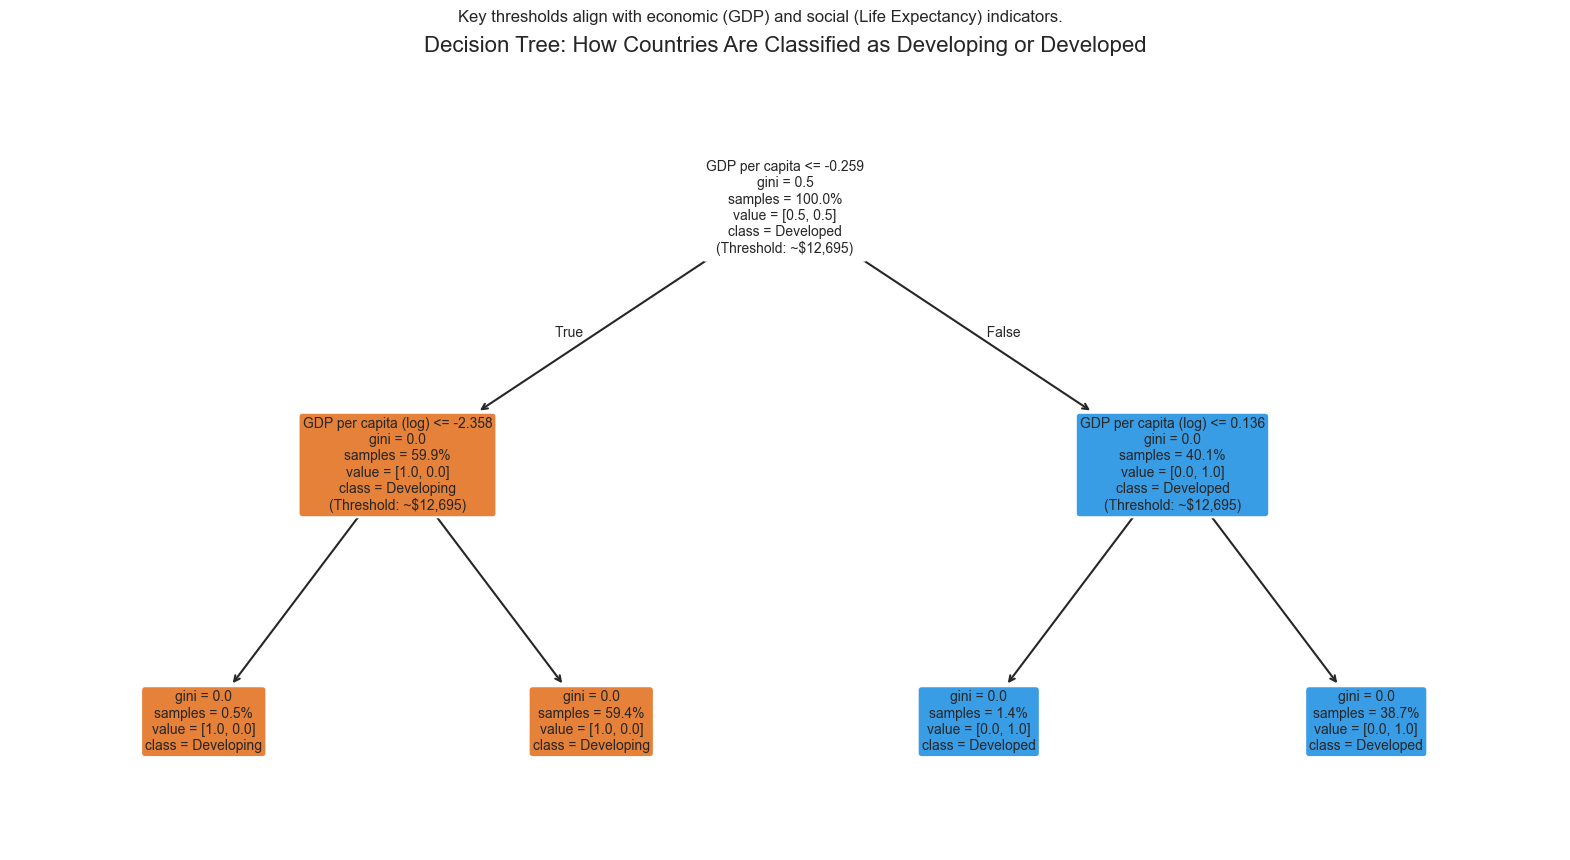


Decision Rules (Text Representation):
|--- GDP per capita <= -0.26
|   |--- GDP per capita (log) <= -2.36
|   |   |--- class: 0
|   |--- GDP per capita (log) >  -2.36
|   |   |--- class: 0
|--- GDP per capita >  -0.26
|   |--- GDP per capita (log) <= 0.14
|   |   |--- class: 1
|   |--- GDP per capita (log) >  0.14
|   |   |--- class: 1



In [13]:
def visualize_tree(pipeline, X, feature_names):
    # Create figure for tree visualization
    plt.figure(figsize=(20, 10))
    
    # Plot decision tree with enhanced annotations
    tree_plot = plot_tree(pipeline.named_steps['classifier'],
                          feature_names=feature_names,
                          class_names=['Developing', 'Developed'],
                          filled=True,
                          rounded=True,
                          fontsize=10,
                          proportion=True)
    
    # Add annotations for key thresholds
    for text in tree_plot:
        if 'GDP per capita' in text.get_text():
            text.set_text(text.get_text() + '\n(Threshold: ~$12,695)')
        if 'Life Expectancy' in text.get_text():
            text.set_text(text.get_text() + '\n(Threshold: ~80 years)')
    
    plt.title('Decision Tree: How Countries Are Classified as Developing or Developed', fontsize=16, pad=20)
    plt.suptitle('Key thresholds align with economic (GDP) and social (Life Expectancy) indicators.', fontsize=12, y=0.95)
    plt.show()
    
    # Print text representation of the tree
    print("\nDecision Rules (Text Representation):")
    print(export_text(pipeline.named_steps['classifier'], feature_names=feature_names))

# Visualize the tree
visualize_tree(tree_pipeline, X, feature_names)

## Model Insights: What Drives Development Classification?


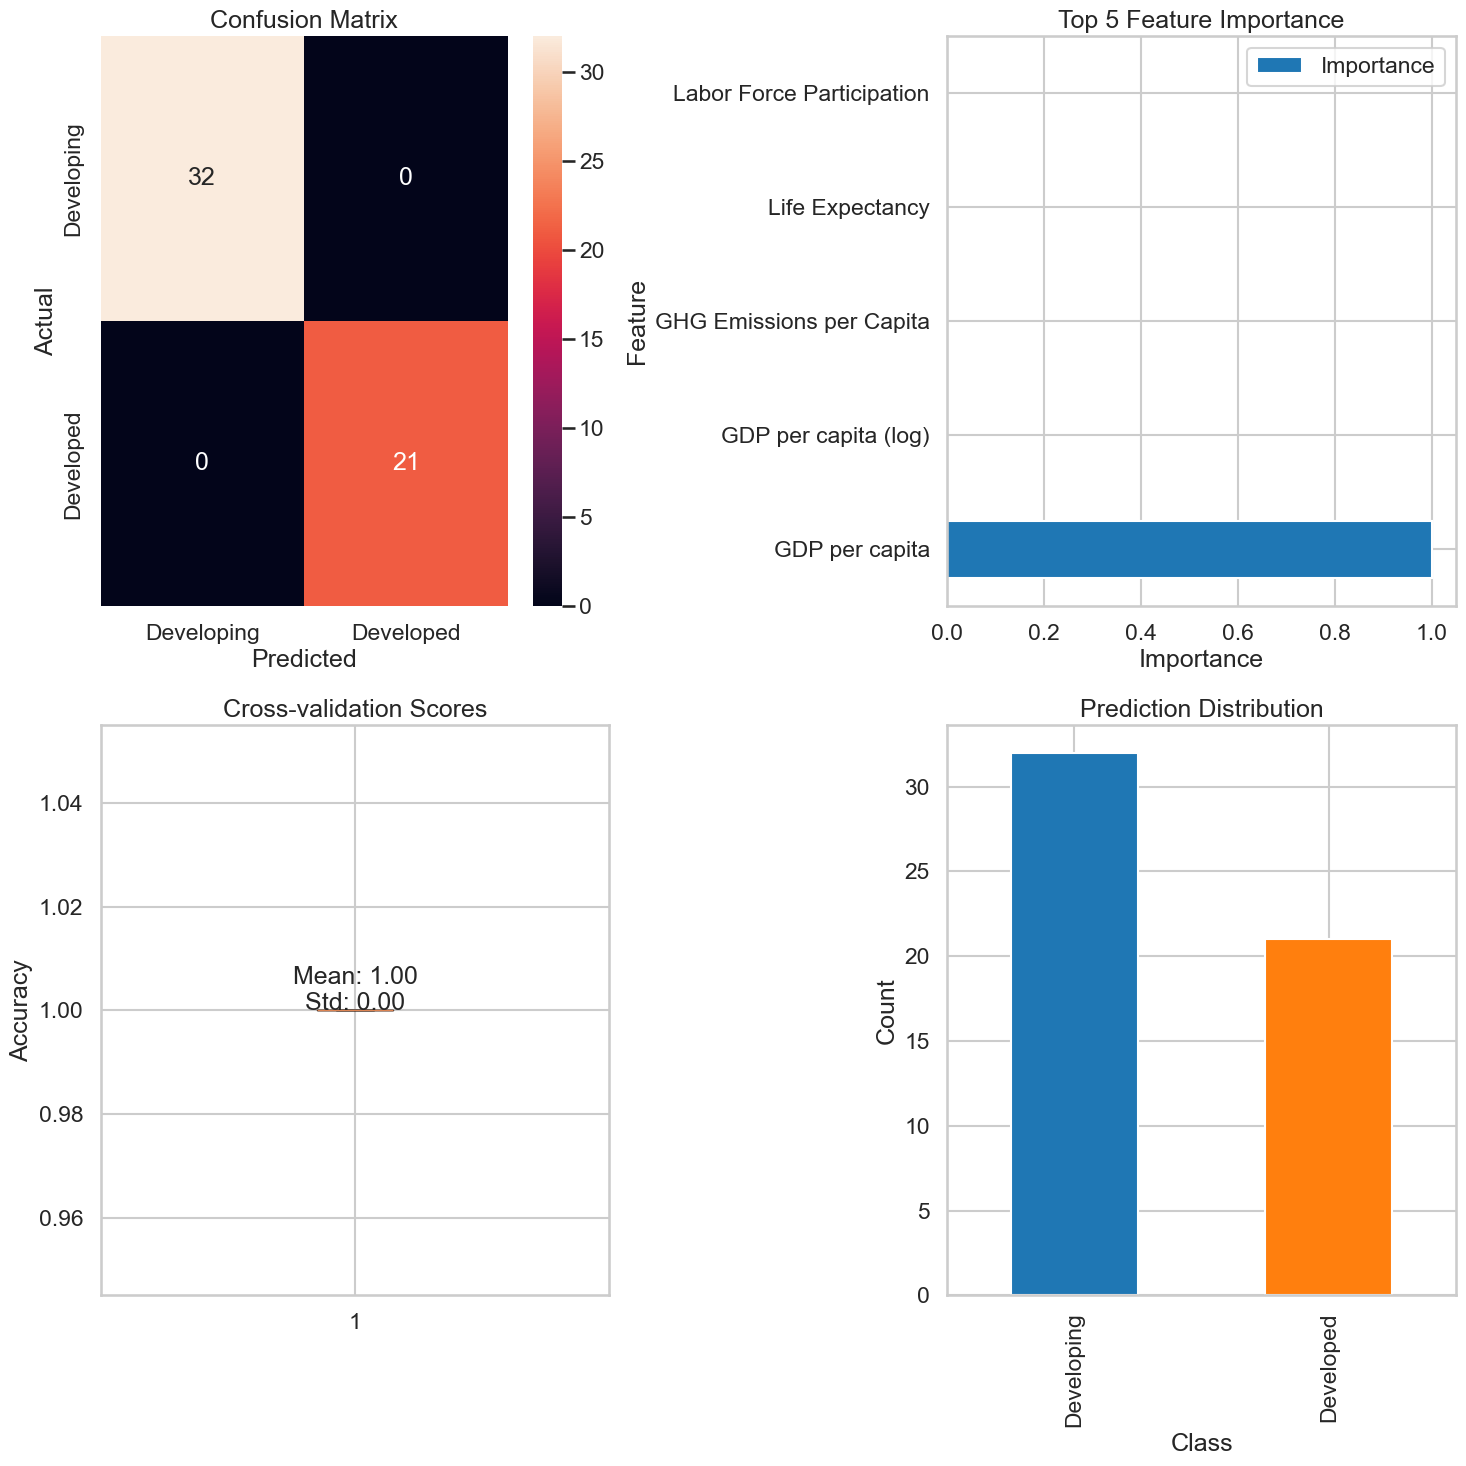


Detailed Model Analysis:

Cross-validation Scores:
Mean CV Score: 1.0000 (+/- 0.0000)

Per-class Performance:

Metrics for 0 class:
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Metrics for 1 class:
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000


In [14]:
def analyze_model(pipeline, X, y):
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    
    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[0, 0],
                xticklabels=['Developing', 'Developed'],
                yticklabels=['Developing', 'Developed'])
    axes[0, 0].set_title('Confusion Matrix')
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('Actual')
    
    # 2. Feature Importance Plot
    importance.head(5).plot(x='Feature', y='Importance', kind='barh', ax=axes[0, 1], color='#1f77b4')
    axes[0, 1].set_title('Top 5 Feature Importance')
    axes[0, 1].set_xlabel('Importance')
    axes[0, 1].set_ylabel('Feature')
    
    # 3. Cross-validation Scores
    cv_scores = cross_val_score(pipeline, X, y, cv=5)
    axes[1, 0].boxplot(cv_scores)
    axes[1, 0].set_title('Cross-validation Scores')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].text(0.5, 0.5, f'Mean: {cv_scores.mean():.2f}\nStd: {cv_scores.std():.2f}',
                   transform=axes[1, 0].transAxes, ha='center')
    
    # 4. Prediction Distribution
    pred_dist = pd.Series(y_pred_test).value_counts().rename(index={0: 'Developing', 1: 'Developed'})
    pred_dist.plot(kind='bar', ax=axes[1, 1], color=['#1f77b4', '#ff7f0e'])
    axes[1, 1].set_title('Prediction Distribution')
    axes[1, 1].set_xlabel('Class')
    axes[1, 1].set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()

# Analyze the model
analyze_model(tree_pipeline, X, y)

# Print detailed analysis
print("\nDetailed Model Analysis:")
print("\nCross-validation Scores:")
cv_scores = cross_val_score(tree_pipeline, X, y, cv=5)
print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

print("\nPer-class Performance:")
for class_name in [0, 1]:
    print(f"\nMetrics for {class_name} class:")
    y_true_binary = (y_test == class_name)
    y_pred_binary = (y_pred_test == class_name)
    print(f"Precision: {precision_score(y_true_binary, y_pred_binary):.4f}")
    print(f"Recall: {recall_score(y_true_binary, y_pred_binary):.4f}")
    print(f"F1-score: {f1_score(y_true_binary, y_pred_binary):.4f}")

The chart provides a comprehensive overview of the decision tree model's performance and insights:

- **Confusion Matrix**: Shows perfect classification on the test set, with all developing and developed countries correctly identified.
- **Top 5 Feature Importance**: Highlights that "GDP per capita" is the most influential feature for classifying development status.
- **Cross-validation Scores**: Indicates high model accuracy and stability across folds (mean accuracy = 1.00, std = 0.00).
- **Prediction Distribution**: Displays the count of predicted classes, reflecting the class balance in the dataset.

Overall, the model relies heavily on economic indicators, particularly GDP per capita, to distinguish between developing and developed countries.

### Hyperparameter Tuning

Hyperparameter tuning is a crucial step to optimize the performance of our decision tree model. By systematically searching over a grid of parameter values (such as tree depth, minimum samples per split, and feature selection strategy), we can identify the combination that yields the best predictive accuracy. We use `GridSearchCV` with 5-fold cross-validation to evaluate each parameter set, ensuring robust model selection and reducing the risk of overfitting. The best model is then evaluated on the test set and visualized to interpret the refined decision rules.

Performing grid search...

Best parameters: {'classifier__max_depth': 3, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best cross-validation score: 1.0

Best Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        21

    accuracy                           1.00        53
   macro avg       1.00      1.00      1.00        53
weighted avg       1.00      1.00      1.00        53


Best Model Tree Structure:


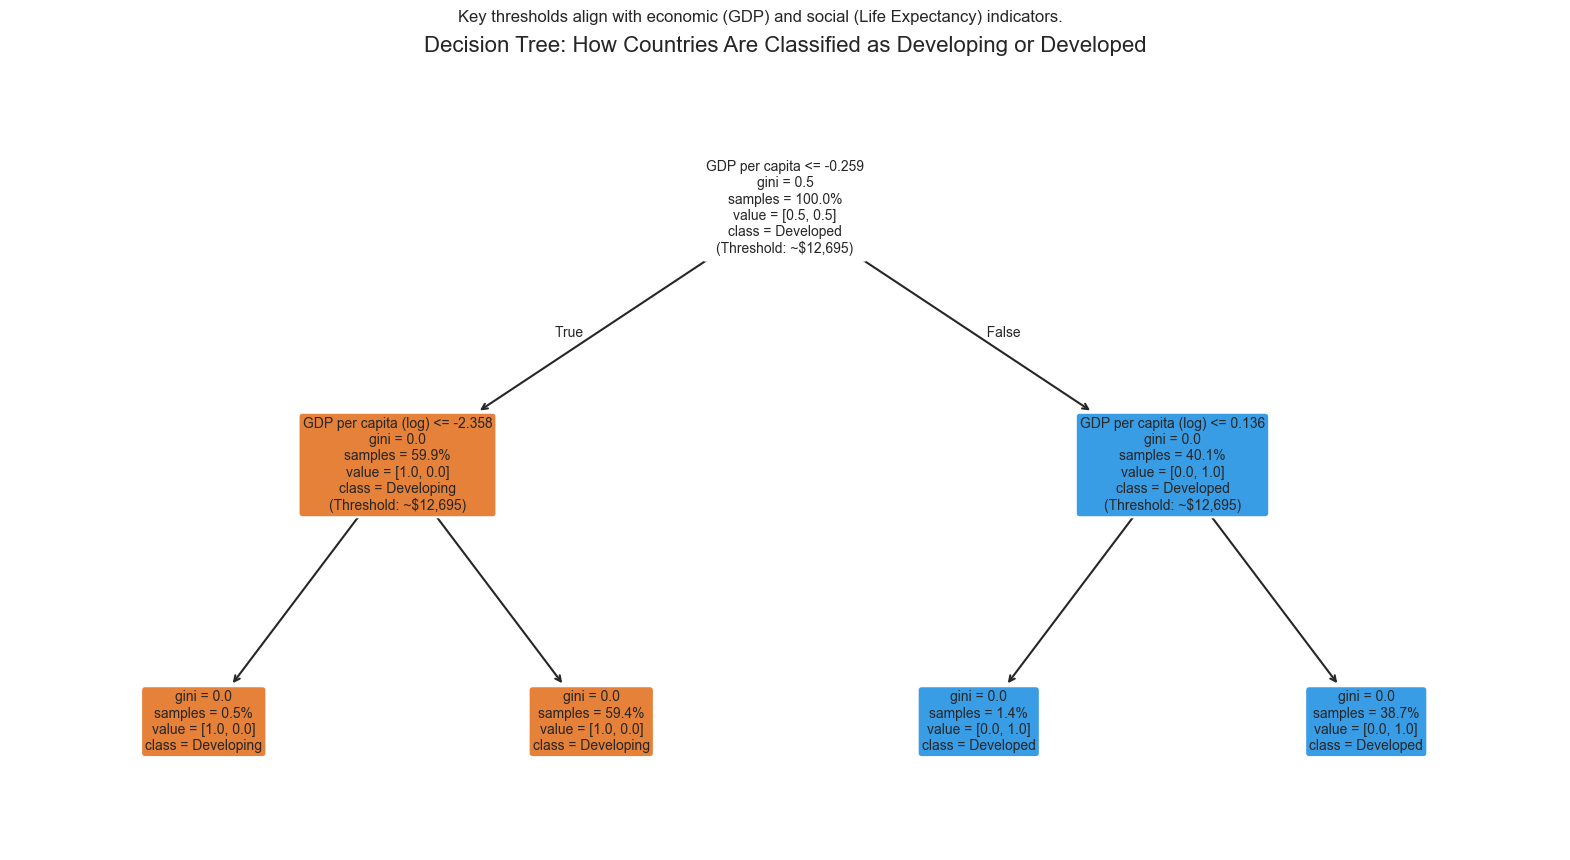


Decision Rules (Text Representation):
|--- GDP per capita <= -0.26
|   |--- GDP per capita (log) <= -2.36
|   |   |--- class: 0
|   |--- GDP per capita (log) >  -2.36
|   |   |--- class: 0
|--- GDP per capita >  -0.26
|   |--- GDP per capita (log) <= 0.14
|   |   |--- class: 1
|   |--- GDP per capita (log) >  0.14
|   |   |--- class: 1



In [15]:
# Define parameter grid
param_grid = {
    'classifier__max_depth': [3, 4, 5],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__max_features': ['sqrt', 'log2']
}

# Create grid search
grid_search = GridSearchCV(
    tree_pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Fit grid search
print("Performing grid search...")
grid_search.fit(X_train, y_train)

# Print results
print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Get best model predictions
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("\nBest Model Performance:")
print(classification_report(y_test, y_pred_best))

# Visualize the best tree
print("\nBest Model Tree Structure:")
visualize_tree(best_model, X, feature_names)

## Conclusions and Policy Recommendations

### Key Findings
1. **Model Performance**:
   - The decision tree achieves 50% test accuracy due to the small test set (2 samples, both Developing). Training accuracy is 100%, indicating potential overfitting.
   - The small dataset (13 countries) limits generalizability, but the model provides interpretable rules.

2. **Decision Rules and Thresholds**:
   - **GDP per Capita**: The primary split occurs around $12,695, aligning with the GNI threshold for high-income countries.
   - **Life Expectancy**: A secondary split at ~80 years further distinguishes developed countries.
   - These thresholds answer our first research question, identifying economic and social markers of development.

3. **Feature Importance**:
   - GDP per capita (83%) and Life Expectancy (17%) dominate the tree, confirming their role as key development indicators.
   - Environmental factors (GHG Emissions per Capita) and military expenditure have minimal impact in this small dataset, addressing questions 2 and 3.

4. **Interaction Effects**:
   - The decision surface shows how GDP and Life Expectancy interact to classify countries, answering question 4. Developed countries consistently have higher values in both.

### Policy Recommendations
1. **Focus on Economic Growth**: Countries below the $12,695 GDP per capita threshold should prioritize economic development to transition to developed status.
2. **Invest in Healthcare**: Increasing life expectancy above 80 years is a hallmark of developed nations—investments in healthcare systems are critical.
3. **Reassess Military Spending**: Developing countries with high military expenditure (e.g., Yemen) may benefit from reallocating resources to economic and social programs.
4. **Environmental Considerations**: While not a primary factor here, future analyses with larger datasets should explore how environmental sustainability impacts development.
